In [1]:
import pandas as pd
import numpy as np
import os
import shutil
import splitfolders
import matplotlib.pyplot as plt
from skimage import transform, io

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import InceptionV3, ResNet152, InceptionResNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, roc_auc_score,roc_curve, auc
from sklearn.preprocessing import label_binarize

import re
import cv2
from PIL import Image

In [2]:
df = pd.read_csv(r"C:\Users\n1109899\Downloads\aptos2019-blindness-detection\train.csv", delimiter=",")
df.head()

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


In [3]:
# Retriving the class list
class_list = df["diagnosis"].unique()
class_list = [int(item) for item in class_list if not np.isnan(item)]
class_list = sorted(class_list)
class_list

[0, 1, 2, 3, 4]

## Preprocessing

In [5]:
def localAvg(img):
    image = cv2.addWeighted(img, 4, cv2.GaussianBlur(img, (0,0), scale/10),-4,128)
    return image

In [6]:
# mask image
def mask_image(img):
    mask = np.zeros(img.shape, dtype = np.uint8)
    center = img.shape[1]//2, img.shape[0]//2
    radius = int(scale * 2.22)

    cv2.circle(mask, center, radius, (1,1,1),-1,8,0)

    image = img * mask + 128 * (1-mask)

    return image

In [7]:
# define preprocessing function
def preprocessing_fun(filename):
    image2 = localAvg(filename)
    image3 = mask_image(image2)
    return image3

In [8]:
scale = 300

In [9]:
# create folder to hold preprocessed imaged
PROCESSED = "processed"
ORIGINAL_IMAGES = "train_images"
if os.path.exists(PROCESSED):
    shutil.rmtree(PROCESSED)
    os.mkdir(PROCESSED)
else:
    os.mkdir(PROCESSED)

In [10]:
# process all images and write to folder
for image in os.listdir(ORIGINAL_IMAGES):
        img_path = os.path.join(ORIGINAL_IMAGES, image)
       
        dest = os.path.join(PROCESSED)
        img = cv2.imread(img_path)
        processed_image = preprocessing_fun(img)
        cv2.imwrite("processed/"+image,processed_image)

## Load and Split dataset

In [4]:
# specify image folder
image_folder = 'processed'
extension = '.png'

In [5]:
# check for dublicates
df.duplicated().sum()

0

In [6]:
# get label df columns
df.columns

Index(['id_code', 'diagnosis'], dtype='object')

In [7]:
# order and load all images and labels into arrays
train_ = []
label_ = []
data = []
dims = 299
for image in df["id_code"]:
    image_file = cv2.imread(os.path.join(image_folder,image+extension))
    image_file = cv2.resize(image_file,(dims,dims))
    idx = df["id_code"].tolist().index(image)
    label = df["diagnosis"][idx]
    
    train_.append(image_file)
    label_.append(label)

train_set = np.array(train_)
train_label = np.array(label_)

In [8]:
X_train1,X_test,y_train1,y_test = train_test_split(train_set,train_label,test_size=0.2, shuffle = True, random_state=42)

In [9]:
X_train, X_val, y_train, y_val = train_test_split(X_train1, y_train1, test_size = 0.2, shuffle = True, random_state = True)

In [10]:
X_train.shape,X_test.shape, X_val.shape

((2343, 299, 299, 3), (733, 299, 299, 3), (586, 299, 299, 3))

In [11]:
y_train.shape,y_test.shape, y_val.shape

((2343,), (733,), (586,))

In [12]:
# function to scale images
def scale(dataset):
    factor = 255.0
    dataset = dataset/factor
    return dataset

In [13]:
# scale images
X_train= scale(X_train)
X_val = scale(X_val)
X_test = scale(X_test)

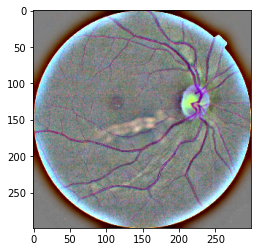

In [14]:
plt.imshow(X_val[76])

## Evaluation functions

In [15]:
# Accuracy and Loss curves
def plot_acc_loss(model_history):
    train_acc = model_history.history['accuracy']
    val_acc = model_history.history['val_accuracy']

    train_loss = model_history.history['loss']
    val_loss = model_history.history['val_loss']

    plt.figure(figsize=(10, 3))
    plt.subplot(1, 2, 1)
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.show()

In [16]:
# display confusion matrix heatmap
def confusion_heatmap(cm):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    fig, ax = plt.subplots(figsize=(7,4), dpi=100)
    ax.set(title='Confusion Matrix for the InceptionV3 model')
    disp.plot(ax = ax)
    plt.show()

In [17]:
# calculate weighted_average specificity
def weighted_average_specificity(cm):
    num_classes = 5
    class_counts = []

    for class_label in range(num_classes):
        # Create  binary classification for the current class
        binary_test = [1 if label == class_label else 0 for label in y_test]
         # Count the number of samples for the current class
        class_counts.append(sum(binary_test))
    print(class_counts)   

    fp = cm.sum(axis=0) - np.diag(cm)  
    fn = cm.sum(axis=1) - np.diag(cm)
    tp = np.diag(cm)
    tn = cm.sum() - (fp + fn + tp)
    specificity = tn/(tn+fp) 

    specificity = np.average(specificity, weights = class_counts)
    return specificity

In [18]:
# calculate macro_average specificity
def macro_average_specificity(cm):

    fp = cm.sum(axis=0) - np.diag(cm)  
    fn = cm.sum(axis=1) - np.diag(cm)
    tp = np.diag(cm)
    tn = cm.sum() - (fp + fn + tp)
    specificity = tn/(tn+fp) 

    specificity =np.mean(specificity)
    return specificity

In [19]:
# Calculate the micro-average AUC
def micro_average_auc(y_pred):
    
    micro_avg_auc = roc_auc_score(y_test, y_pred, multi_class='ovr')
    return micro_avg_auc



In [20]:
# roc curve
def roc_plot(y_pred):

# Binarize actual test labels 
    y_test_cat = label_binarize(y_test, classes=np.arange(num_classes))

    # Compute the ROC curve and AUC for the micro-average
    fpr, tpr, _ = roc_curve(y_test_cat.ravel(), y_pred.ravel())
   
    # Plot the micro-average ROC curve
    plt.figure(figsize=(6, 4))
    
    plt.plot(fpr, tpr, color='deeppink', linestyle='-', lw=1)         

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Micro-Average Receiver Operating Characteristic (ROC) Curve')
    plt.show()


## Model Development and Training

In [21]:
# function to build model
def build_model(pre_trained_network):
    base_model = pre_trained_network(weights = 'imagenet', include_top = False, input_shape = (dims,dims,colour_channel))
    
    for layers in base_model.layers:
        layers.trainable = False

    model = Sequential()
    model.add(base_model)
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(dropout))
    model.add(Dense(num_classes, activation = 'softmax'))
    print(model.summary())
    
    #compile model
    #specify optimizer, loss
    adam = tf.keras.optimizers.Adam(learning_rate = lr)
    loss = tf.keras.losses.SparseCategoricalCrossentropy()

    model.compile(optimizer = adam, loss = loss, metrics = METRICS)
    
    return model

In [22]:
colour_channel =3
epochs = 50
lr = 0.001
METRICS=['accuracy']
batch_size = 32
patience = 10
num_classes = 5
dropout = 0.5
callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = patience)

### Build and train model 1 - Inception V3

In [23]:
InceptionV3_model = build_model(InceptionV3)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 5)                 10245     
                                                                 
Total params: 21813029 (83.21 MB)
Trainable params: 10245 (40.02 KB)
Non-trainable params: 21802784 (83.17 MB)
_________________________________________________________________
None


In [24]:
InceptionV3_model_history = InceptionV3_model.fit(X_train, y_train, batch_size = batch_size, epochs = epochs, validation_data =(X_val, y_val), shuffle = True, callbacks = [callback])
                                            

Epoch 1/50
74/74 [==============================] - 76s 996ms/step - loss: 1.0667 - accuracy: 0.6197 - val_loss: 0.7607 - val_accuracy: 0.7321
Epoch 2/50
74/74 [==============================] - 73s 986ms/step - loss: 0.8348 - accuracy: 0.7021 - val_loss: 0.7009 - val_accuracy: 0.7389
Epoch 3/50
74/74 [==============================] - 74s 1s/step - loss: 0.7503 - accuracy: 0.7166 - val_loss: 0.6900 - val_accuracy: 0.7457
Epoch 4/50
74/74 [==============================] - 75s 1s/step - loss: 0.7214 - accuracy: 0.7375 - val_loss: 0.6460 - val_accuracy: 0.7560
Epoch 5/50
74/74 [==============================] - 76s 1s/step - loss: 0.6965 - accuracy: 0.7362 - val_loss: 0.6357 - val_accuracy: 0.7645
Epoch 6/50
74/74 [==============================] - 80s 1s/step - loss: 0.6741 - accuracy: 0.7469 - val_loss: 0.6415 - val_accuracy: 0.7611
Epoch 7/50
74/74 [==============================] - 81s 1s/step - loss: 0.6529 - accuracy: 0.7465 - val_loss: 0.6229 - val_accuracy: 0.7594
Epoch 8/50
74/

In [25]:
# save model
InceptionV3_model.save('preprocessed_InceptionV3_model1.h5')

C:\ProgramData\Anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


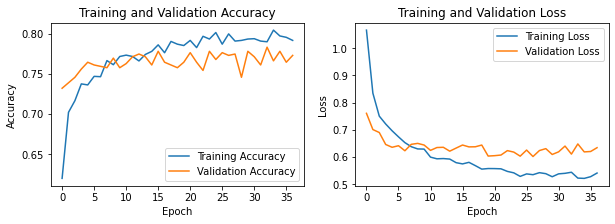

In [26]:
plot_acc_loss(InceptionV3_model_history)

### Evaluate Inception model 

In [27]:
# Predict on test set
inceptionv3_y_pred = InceptionV3_model.predict(X_test)

23/23 [==============================] - 19s 775ms/step


In [28]:
# Classification report
inceptionv3_y_pred_labels = np.argmax(inceptionv3_y_pred, axis=1)
print(classification_report(y_test, inceptionv3_y_pred_labels))

              precision    recall  f1-score   support

           0       0.90      0.99      0.94       351
           1       0.65      0.38      0.48        68
           2       0.62      0.83      0.71       213
           3       0.56      0.14      0.22        36
           4       0.44      0.11      0.17        65

    accuracy                           0.77       733
   macro avg       0.63      0.49      0.51       733
weighted avg       0.74      0.77      0.73       733



In [29]:
# Confusion matrix
inceptionv3_conf_matrix = confusion_matrix(y_test, inceptionv3_y_pred_labels)

inceptionv3_conf_matrix

array([[346,   4,   1,   0,   0],
       [ 16,  26,  25,   0,   1],
       [ 17,   8, 177,   3,   8],
       [  0,   1,  30,   5,   0],
       [  5,   1,  51,   1,   7]], dtype=int64)

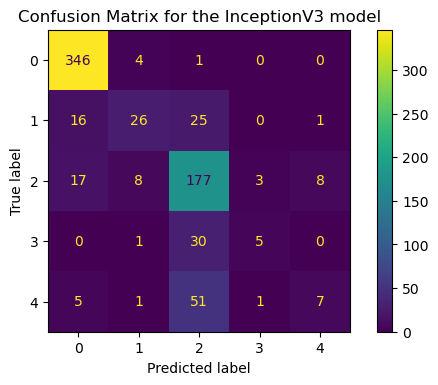

In [30]:
# confusion matrix
confusion_heatmap(inceptionv3_conf_matrix)

In [31]:
# weighted average specificity
inception_wa_specificity = weighted_average_specificity(inceptionv3_conf_matrix)
print(inception_wa_specificity)

[351, 68, 213, 36, 65]
0.8891418776483536


In [32]:
inception_ma_specificity = macro_average_specificity(inceptionv3_conf_matrix)
print(inception_ma_specificity)

0.9308979526101618


In [33]:
micro_avg_auc = micro_average_auc(inceptionv3_y_pred)
print("Micro-Average AUC:", micro_avg_auc)


Micro-Average AUC: 0.8812587922049433


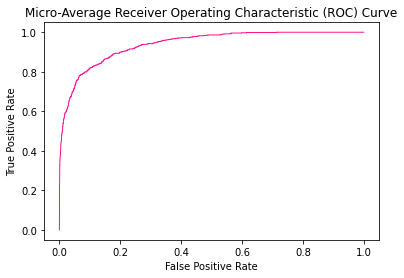

In [34]:
roc_plot(inceptionv3_y_pred)

## Build and train model 2 - ResNet152

In [35]:
# build and compile model
resnet152_model = build_model(ResNet152)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152 (Functional)      (None, 10, 10, 2048)      58370944  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                                 
 dense_1 (Dense)             (None, 5)                 10245     
                                                                 
Total params: 58381189 (222.71 MB)
Trainable params: 10245 (40.02 KB)
Non-trainable params: 58370944 (222.67 MB)
_________________________________________________________________
None


In [36]:
# fit resnet model
resnet152_model_history = resnet152_model.fit(X_train, y_train, batch_size = batch_size, epochs = epochs, validation_data =(X_val, y_val), shuffle = True, callbacks = [callback])


Epoch 1/50
74/74 [==============================] - 365s 5s/step - loss: 1.4100 - accuracy: 0.4806 - val_loss: 1.1062 - val_accuracy: 0.6348
Epoch 2/50
74/74 [==============================] - 378s 5s/step - loss: 1.2211 - accuracy: 0.5267 - val_loss: 1.0280 - val_accuracy: 0.6041
Epoch 3/50
74/74 [==============================] - 373s 5s/step - loss: 1.1810 - accuracy: 0.5280 - val_loss: 1.0115 - val_accuracy: 0.6160
Epoch 4/50
74/74 [==============================] - 388s 5s/step - loss: 1.1639 - accuracy: 0.5412 - val_loss: 1.0428 - val_accuracy: 0.6399
Epoch 5/50
74/74 [==============================] - 378s 5s/step - loss: 1.1577 - accuracy: 0.5493 - val_loss: 1.0370 - val_accuracy: 0.6741
Epoch 6/50
74/74 [==============================] - 377s 5s/step - loss: 1.1195 - accuracy: 0.5723 - val_loss: 1.0207 - val_accuracy: 0.6843
Epoch 7/50
74/74 [==============================] - 390s 5s/step - loss: 1.0924 - accuracy: 0.5715 - val_loss: 1.0181 - val_accuracy: 0.6416
Epoch 8/50
74

In [37]:
# save model
resnet152_model.save('saved_models/processed_ResNet152_model.h5')

C:\ProgramData\Anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


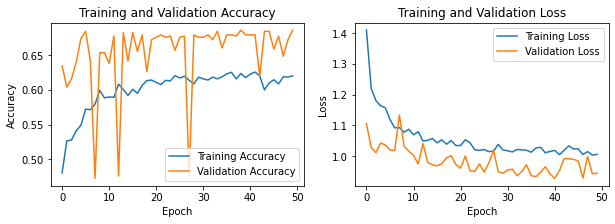

In [38]:
plot_acc_loss(resnet152_model_history)

### Evaluate ResNet152 model

In [39]:
# Predict on test set
resnet152_y_pred = resnet152_model.predict(X_test)

23/23 [==============================] - 93s 4s/step


In [40]:
# Classification report
resnet152_y_pred_labels = np.argmax(resnet152_y_pred, axis=1)
print(classification_report(y_test, resnet152_y_pred_labels))

              precision    recall  f1-score   support

           0       0.88      0.88      0.88       351
           1       0.00      0.00      0.00        68
           2       0.51      0.92      0.66       213
           3       0.00      0.00      0.00        36
           4       0.00      0.00      0.00        65

    accuracy                           0.69       733
   macro avg       0.28      0.36      0.31       733
weighted avg       0.57      0.69      0.61       733



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [41]:
# Confusion matrix
resnet152_conf_matrix = confusion_matrix(y_test, resnet152_y_pred_labels)

print(resnet152_conf_matrix)

[[310   0  41   0   0]
 [ 10   0  58   0   0]
 [ 18   0 195   0   0]
 [  4   0  32   0   0]
 [  9   0  56   0   0]]


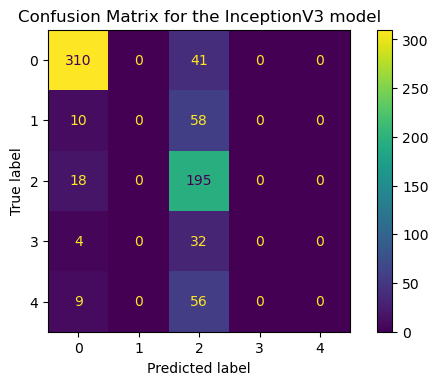

In [42]:
# confusion matrix heatmap
confusion_heatmap(resnet152_conf_matrix)

In [43]:
# weighted average specificity
resnet152_wa_specificity = weighted_average_specificity(resnet152_conf_matrix)
print(resnet152_wa_specificity)

[351, 68, 213, 36, 65]
0.8441052499424462


In [44]:
# macro avg specificity
resnet152_ma_specificity = macro_average_specificity(resnet152_conf_matrix)
print(resnet152_ma_specificity)

0.9066109544905355


In [45]:
# micro_avg AUC
micro_avg_auc = micro_average_auc(resnet152_y_pred)
print("ResNet152 Micro-Average AUC:", micro_avg_auc)


ResNet152 Micro-Average AUC: 0.8019763525645667


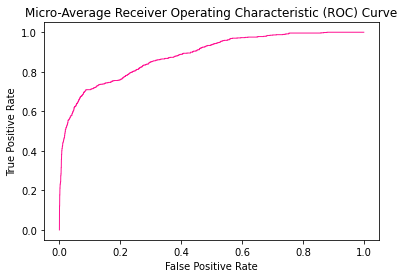

In [46]:
roc_plot(resnet152_y_pred)

## Build and train model 3 - InceptionResNetV2

In [47]:
# build anad compile model
inceptionResnet_model = build_model(InceptionResNetV2)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Funct  (None, 8, 8, 1536)        54336736  
 ional)                                                          
                                                                 
 global_average_pooling2d_2  (None, 1536)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_2 (Dropout)         (None, 1536)              0         
                                                                 
 dense_2 (Dense)             (None, 5)                 7685      
                                                                 
Total params: 54344421 (207.31 MB)
Trainable params: 7685 (30.02 KB)
Non-trainable params: 54336736 (207.28 MB)
_________________________________________________________________
None


In [48]:
# fit resnet model
inceptionResnet_model_history = inceptionResnet_model.fit(X_train, y_train, batch_size = batch_size, epochs = epochs, validation_data =(X_val, y_val),shuffle = True, callbacks = [callback])


Epoch 1/50
74/74 [==============================] - 221s 3s/step - loss: 1.1193 - accuracy: 0.5809 - val_loss: 0.7976 - val_accuracy: 0.7150
Epoch 2/50
74/74 [==============================] - 205s 3s/step - loss: 0.9113 - accuracy: 0.6650 - val_loss: 0.7614 - val_accuracy: 0.7235
Epoch 3/50
74/74 [==============================] - 194s 3s/step - loss: 0.8344 - accuracy: 0.6923 - val_loss: 0.7430 - val_accuracy: 0.7218
Epoch 4/50
74/74 [==============================] - 192s 3s/step - loss: 0.7835 - accuracy: 0.7042 - val_loss: 0.6957 - val_accuracy: 0.7474
Epoch 5/50
74/74 [==============================] - 198s 3s/step - loss: 0.7770 - accuracy: 0.7145 - val_loss: 0.6814 - val_accuracy: 0.7491
Epoch 6/50
74/74 [==============================] - 201s 3s/step - loss: 0.7505 - accuracy: 0.7243 - val_loss: 0.6963 - val_accuracy: 0.7406
Epoch 7/50
74/74 [==============================] - 201s 3s/step - loss: 0.7401 - accuracy: 0.7281 - val_loss: 0.6810 - val_accuracy: 0.7440
Epoch 8/50
74

In [49]:
# save model
inceptionResnet_model.save('saved_models/processed_inceptionResnet_model.h5')

C:\ProgramData\Anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


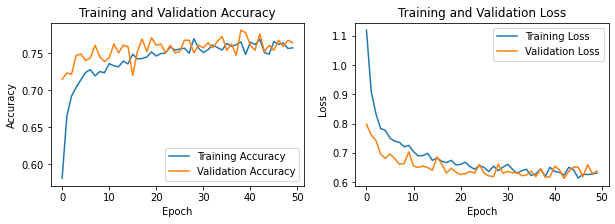

In [50]:
# plot loss and accuracy
plot_acc_loss(inceptionResnet_model_history)

### Evaluate InceptionResNetV2 model

In [51]:
# Predict on test set
inceptionResnet_y_pred = inceptionResnet_model.predict(X_test)

23/23 [==============================] - 55s 2s/step


In [52]:
# Classification report
inceptionResnet_y_pred_labels = np.argmax(inceptionResnet_y_pred, axis=1)
print(classification_report(y_test, inceptionResnet_y_pred_labels))

              precision    recall  f1-score   support

           0       0.92      0.97      0.95       351
           1       0.52      0.46      0.48        68
           2       0.66      0.74      0.69       213
           3       0.38      0.17      0.23        36
           4       0.33      0.23      0.27        65

    accuracy                           0.75       733
   macro avg       0.56      0.51      0.53       733
weighted avg       0.73      0.75      0.74       733



In [53]:
# Confusion matrix
inceptionResnet_conf_matrix = confusion_matrix(y_test, inceptionResnet_y_pred_labels)

print(inceptionResnet_conf_matrix)

[[342   6   1   0   2]
 [ 12  31  19   0   6]
 [ 13  18 157   6  19]
 [  1   1  24   6   4]
 [  4   4  38   4  15]]


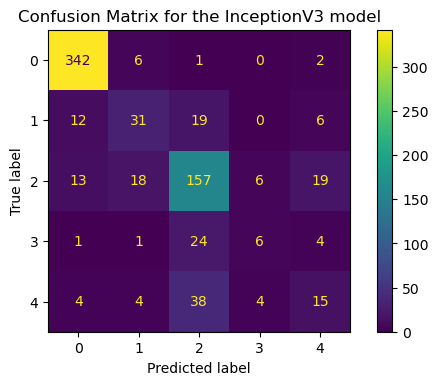

In [54]:
# confusion matrix heatmap
confusion_heatmap(inceptionResnet_conf_matrix)

In [55]:
# weighted average specificity
inceptionResnet_wa_specificity = weighted_average_specificity(inceptionResnet_conf_matrix)
print(inceptionResnet_wa_specificity)

[351, 68, 213, 36, 65]
0.9077049298131211


In [56]:
# macro avg specificity
inceptionResnet_ma_specificity = macro_average_specificity(inceptionResnet_conf_matrix)
print(inceptionResnet_ma_specificity)

0.9318820500826789


In [57]:
# micro_avg AUC
micro_avg_auc = micro_average_auc(inceptionResnet_y_pred)
print("InceptionResNet Micro-Average AUC:", micro_avg_auc)


InceptionResNet Micro-Average AUC: 0.8867328806285316


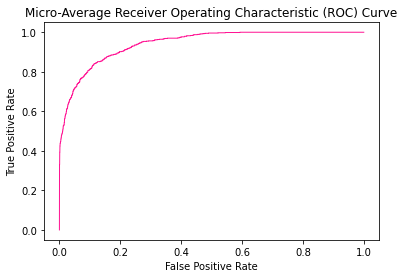

In [58]:
roc_plot(inceptionResnet_y_pred)

### Averaging

In [60]:
model1 = InceptionV3_model
model2 = resnet152_model
model3 = inceptionResnet_model

In [61]:
models = [model1, model2, model3]

In [62]:
preds = [model.predict(X_test) for model in models]

23/23 [==============================] - 54s 2s/step


In [63]:
pred = np.array(preds)

In [65]:
summed = np.sum(preds, axis=0)


In [91]:
mean_preds = np.mean(preds, axis = 0)

In [66]:
# argmax across classes
ensemble_prediction = np.argmax(summed, axis=1)

In [67]:
print(classification_report(y_test, ensemble_prediction))

              precision    recall  f1-score   support

           0       0.90      0.99      0.94       351
           1       0.59      0.29      0.39        68
           2       0.61      0.85      0.72       213
           3       0.62      0.14      0.23        36
           4       0.27      0.05      0.08        65

    accuracy                           0.76       733
   macro avg       0.60      0.46      0.47       733
weighted avg       0.72      0.76      0.71       733



In [81]:
# Confusion matrix
ensemble_conf_matrix = confusion_matrix(y_test, ensemble_prediction)

print(ensemble_conf_matrix)

[[346   3   2   0   0]
 [ 14  20  33   0   1]
 [ 17   8 182   1   5]
 [  0   0  29   5   2]
 [  7   3  50   2   3]]


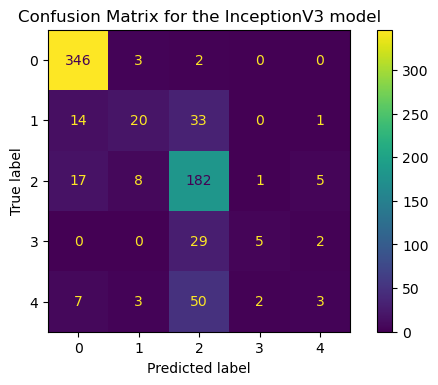

In [82]:
# confusion matrix
confusion_heatmap(ensemble_conf_matrix)

In [83]:
# weighted average specificity
ensemble_wa_specificity = weighted_average_specificity(ensemble_conf_matrix)
print(ensemble_wa_specificity)

[351, 68, 213, 36, 65]
0.8854333478054859


In [84]:
# macro avg specificity
ensemble_ma_specificity = macro_average_specificity(ensemble_conf_matrix)
print(inceptionResnet_ma_specificity)

0.9318820500826789


In [92]:
# micro_avg AUC
micro_avg_auc = micro_average_auc(mean_preds)
print("Ensembled model Micro-Average AUC:", micro_avg_auc)


Ensembled model Micro-Average AUC: 0.8838427268546957


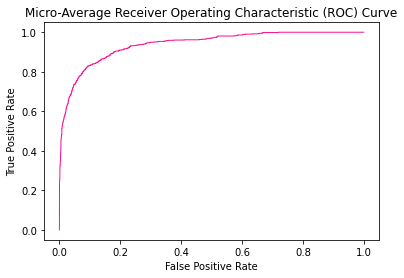

In [94]:
roc_plot(mean_preds)

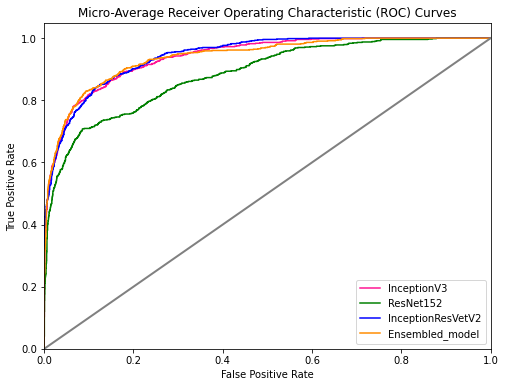

In [99]:
# Binarize actual test labels 
y_test_cat = label_binarize(y_test, classes=np.arange(num_classes))
# Compute the ROC curves for each model
fpr_inception, tpr_inception, _ = roc_curve(y_test_cat.ravel(), inceptionv3_y_pred.ravel())
fpr_resnet, tpr_resnet, _ = roc_curve(y_test_cat.ravel(), resnet152_y_pred.ravel())
fpr_inceptionResnet, tpr_inceptionResnet, _ = roc_curve(y_test_cat.ravel(), inceptionResnet_y_pred.ravel())
fpr_ensemble, tpr_ensemble, _ = roc_curve(y_test_cat.ravel(), mean_preds.ravel())

# Plot the ROC curves for each model
plt.figure(figsize=(8, 6))

plt.plot(fpr_inception, tpr_inception, color='deeppink', lw=1.5, label= 'InceptionV3')
plt.plot(fpr_resnet, tpr_resnet, color='green', lw=1.5, label= 'ResNet152')
plt.plot(fpr_inceptionResnet, tpr_inceptionResnet, color='blue', lw=1.5, label= 'InceptionResVetV2')
plt.plot(fpr_ensemble, tpr_ensemble, color='darkorange', lw=1.5, label= 'Ensembled_model')
 
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='-')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Micro-Average Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.show()

In [68]:
ensemble_accuracy = accuracy_score(y_test, ensemble_prediction)

In [69]:
print('Accuracy Score for average ensemble = ', ensemble_accuracy)

Accuracy Score for average ensemble =  0.7585266030013642
